# Plot params across channels
<p>created: Sep 16, 2024 <br>
last modified: Sep 18, 2024 </p>
<p>
Plot histogram of LFP spectral parameterization results (exponent, r-squared, offset, and stimulus-evoked changes in these parameters), epoched. Additionally, plot a segment of our time-series (move this part to a different notebook later)</p>

In [ ]:
# Autoreload
%load_ext autoreload
%autoreload 2

#### Imports

In [29]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from neurodsp.utils import create_times
from scipy.stats import zscore

# custom
import sys
sys.path.append("../../code")
from paths import PROJECT_PATH, EXTERNAL_PATH
from info import SESSIONS, FS, EPOCH_TIMES, TOTAL_CHANS
from plots import plot_event_traces, plot_spectra_2conditions, plot_psd_diff, plot_schematic, plot_regression
from utils import compute_confidence_interval, subtract_baseline
from tfr_utils import load_tfr_results, plot_evoked_tfr, preprocess_tfr


In [3]:
# settings
plt.style.use('../../mpl_styles/default.mplstyle')

# set variables of interest
vars = ['offset', 'knee', 'exponent']

#### Main

In [29]:
# load spectral parameters
params = pd.read_csv(fr"{EXTERNAL_PATH}\data\results\lfp_spectral_params.csv")
params

,Unnamed: 0,session,channel,chan_idx,array,epoch,offset,knee,exponent,alpha_cf,alpha_pw,alpha_bw,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared
0,0,A_SNR_140819,0,0,1,pre,5.774364,-6.789797,2.264008,9.805430,0.663349,5.275753,17.365468,0.618030,10.053661,60.675713,0.575678,2.164377,0.064003,0.994617
1,1,A_SNR_140819,1,1,1,pre,6.041152,4.586532,2.449866,NaN,NaN,NaN,16.674368,0.648848,12.000000,60.706228,0.607547,2.080446,0.075752,0.991611
2,2,A_SNR_140819,2,2,1,pre,5.513418,-3.240593,1.956623,10.471750,0.483946,4.875697,17.742891,0.396295,12.000000,60.127900,0.400871,2.001077,0.065324,0.990826
3,3,A_SNR_140819,3,3,1,pre,6.029085,7.909415,2.459045,NaN,NaN,NaN,17.123952,0.615339,12.000000,60.970030,0.667564,2.000000,0.074475,0.991993
4,4,A_SNR_140819,4,4,1,pre,5.998930,7.405537,2.411469,NaN,NaN,NaN,17.093011,0.599103,12.000000,60.682388,0.671076,2.228288,0.071394,0.992443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,L_SNR_250717,59,1019,16,post,6.597218,-4.360148,1.914368,NaN,NaN,NaN,17.007503,0.306629,4.252543,58.515674,0.536050,2.157331,0.077426,0.984753
4092,4092,L_SNR_250717,60,1020,16,post,7.235486,25.438139,2.209834,NaN,NaN,NaN,24.249733,0.229140,2.187178,58.665548,0.454112,2.211706,0.067791,0.986501
4093,4093,L_SNR_250717,61,1021,16,post,7.419636,29.715929,2.295010,NaN,NaN,NaN,23.629867,0.242662,3.318244,58.638905,0.432759,2.142921,0.072445,0.988839
4094,4094,L_SNR_250717,62,1022,16,post,7.256606,15.471685,2.214591,NaN,NaN,NaN,25.983614,0.255546,11.720273,58.680252,0.466644,2.000000,0.073304,0.987195


In [11]:
params[(params['session']  == 'A_SNR_140819') & (params['epoch'] == 'pre')].get('offset')

0       5.774364
1       6.041152
2       5.513418
3       6.029085
4       5.998930
          ...   
1019    6.435436
1020    6.393797
1021    6.419265
1022    6.833788
1023    6.580193
Name: offset, Length: 1024, dtype: float64

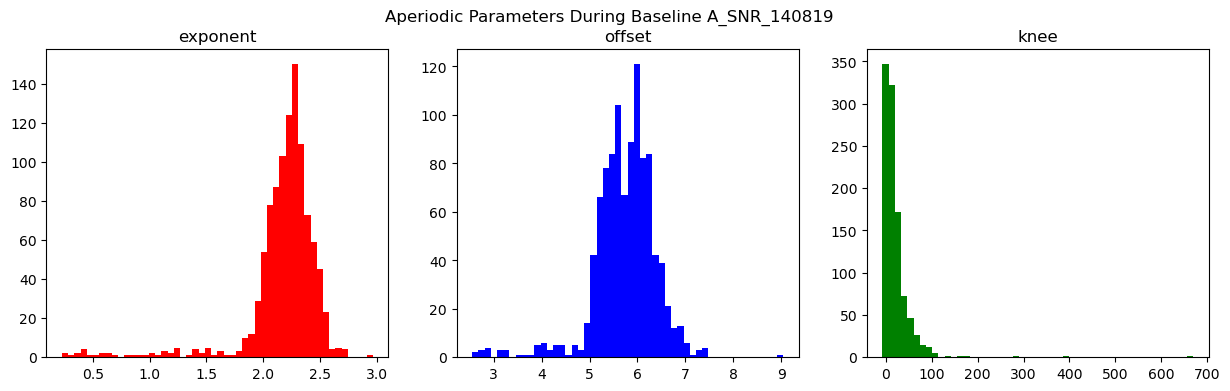

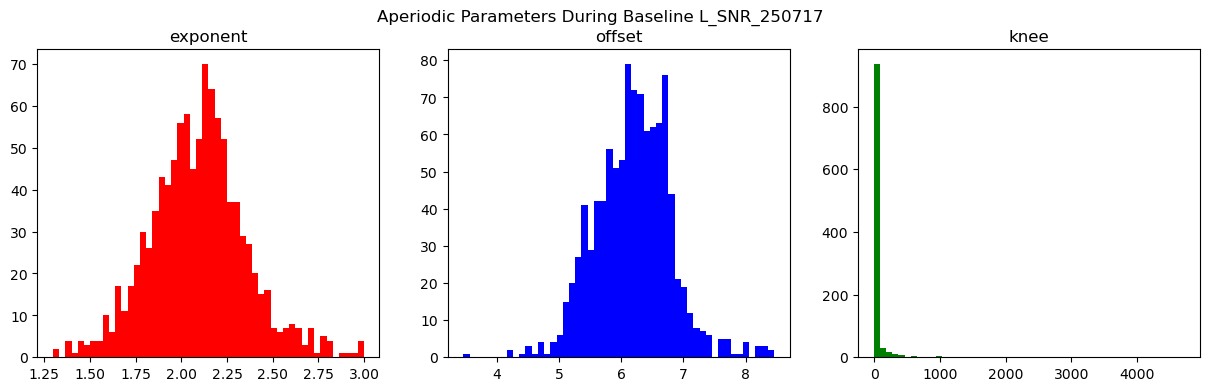

In [22]:
# plot params histogram for baseline
for session in SESSIONS:
    df = params[(params['session']  == session) & (params['epoch'] == 'pre')]

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
    #exp
    ax1.hist(df.get('exponent'), bins=50, color='red')
    ax1.set_title('exponent')

    #off
    ax2.hist(df.get('offset'), bins=50, color='blue')
    ax2.set_title('offset')

    #knee
    ax3.hist(df.get('knee'), bins=50, color='green')
    ax3.set_title('knee')

    fig.suptitle(f'Aperiodic Parameters During Baseline {session}')

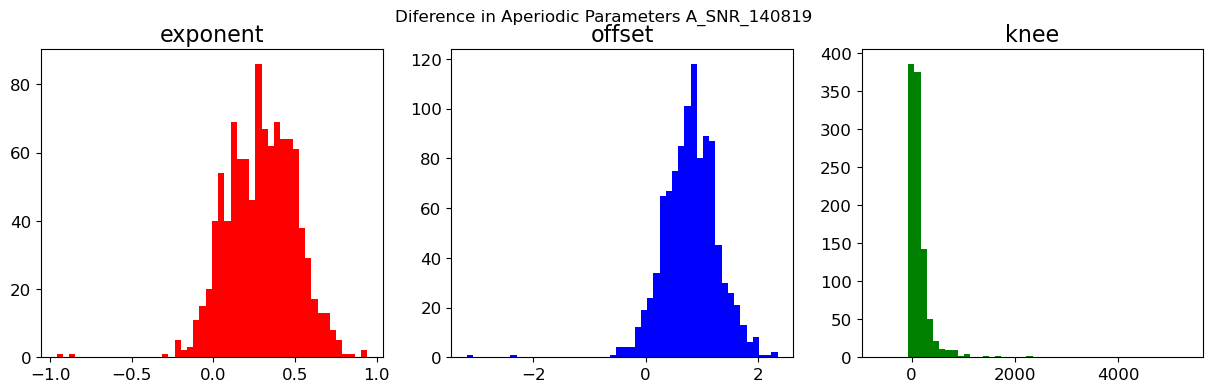

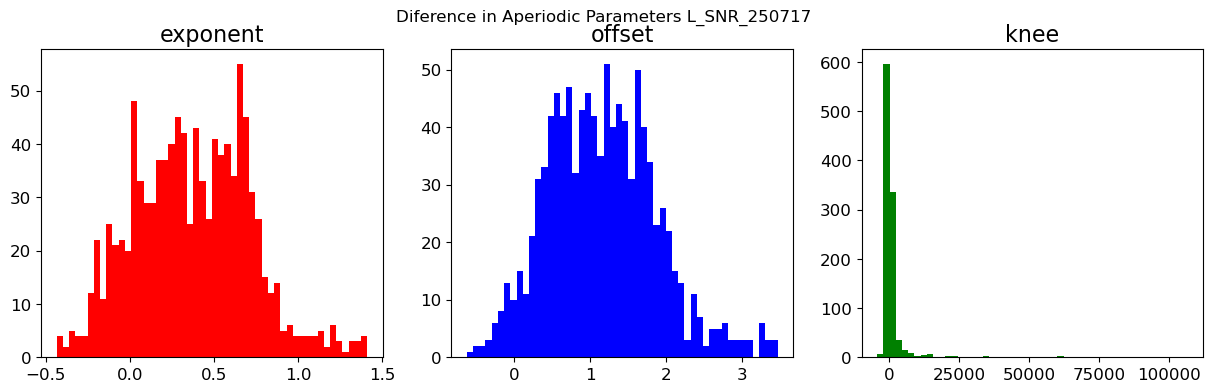

In [34]:
# plot params histogram for difference
for session in SESSIONS:
    df_pre = params[(params['session']  == session) & (params['epoch'] == 'pre')]
    df_post = params[(params['session']  == session) & (params['epoch'] == 'post')]

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

    #exp
    exponent = df_post['exponent'].values - df_pre['exponent'].values 
    ax1.hist(exponent, bins=50, color='red')
    ax1.set_title('exponent')

    #off
    offset = df_post['offset'].values - df_pre['offset'].values 
    ax2.hist(offset, bins=50, color='blue')
    ax2.set_title('offset')

    #knee
    knee = df_post['knee'].values - df_pre['knee'].values
    ax3.hist(knee, bins=50, color='green')
    ax3.set_title('knee')

    fig.suptitle(f'Diference in Aperiodic Parameters {session}')

## Epoched Time Series

In [23]:
lfp = np.load(fr"{EXTERNAL_PATH}\data\lfp\lfp_epochs\A_SNR_140819\NSP6_array11_LFP.npy")

In [25]:
lfp.shape

(170, 64, 500)

In [112]:
# create time-vector
n_seconds = lfp.shape[2]/FS
time = create_times(n_seconds, FS)
print(time.shape)

# set signal
signal = lfp[1,1,:]
signal.shape

(500,)


(500,)

Text(0.5, 0, 'time (s)')

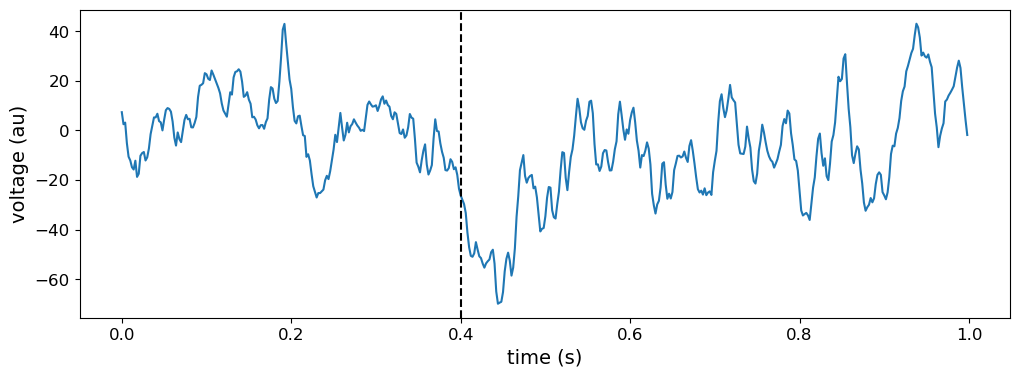

In [123]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(time, signal)
ax.axvline(x=0.4, c='black', linestyle='--')
ax.set_ylabel('voltage (au)')
ax.set_xlabel('time (s)')

## Analyze spectral epoch difference

In [4]:
for session in SESSIONS:
    print(session)

A_SNR_140819
L_SNR_250717


In [5]:
dir_input = f"{EXTERNAL_PATH}/data/lfp/lfp_psd"
data = np.load(f"{dir_input}/A_SNR_140819_spectra.npz")

In [8]:
for x in data.keys():
    print(x)

spectra_pre
spectra_post
freq


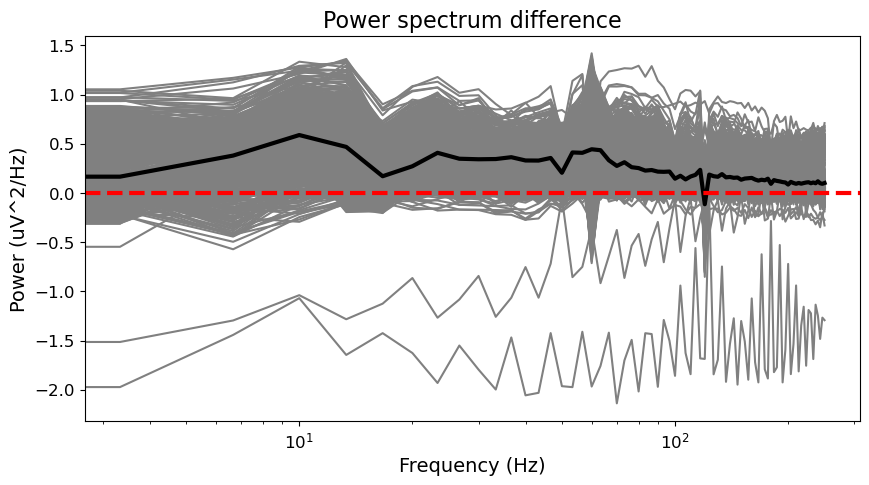

In [13]:
spectra_pre = np.nanmean(data['spectra_pre'], axis=0)
spectra_post = np.nanmean(data['spectra_post'], axis=0)
psd_diff = np.log10(spectra_post) - np.log10(spectra_pre)
plot_psd_diff(data['freq'], psd_diff)

## Plot Schematic differences

In [3]:
# load NEW spectral parameters
df = pd.read_csv(fR"{EXTERNAL_PATH}\data\results\lfp_spectral_params.csv", index_col=0)
df

,session,channel,chan_idx,array,epoch,offset,knee,exponent,alpha_cf,alpha_pw,alpha_bw,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared
0,A_SNR_140819,0,0,1,pre,5.774364,-6.789797,2.264008,9.805430,0.663349,5.275753,17.365468,0.618030,10.053661,60.675713,0.575678,2.164377,0.064003,0.994617
1,A_SNR_140819,1,1,1,pre,6.041152,4.586532,2.449866,NaN,NaN,NaN,16.674368,0.648848,12.000000,60.706228,0.607547,2.080446,0.075752,0.991611
2,A_SNR_140819,2,2,1,pre,5.513418,-3.240593,1.956623,10.471750,0.483946,4.875697,17.742891,0.396295,12.000000,60.127900,0.400871,2.001077,0.065324,0.990826
3,A_SNR_140819,3,3,1,pre,6.029085,7.909415,2.459045,NaN,NaN,NaN,17.123952,0.615339,12.000000,60.970030,0.667564,2.000000,0.074475,0.991993
4,A_SNR_140819,4,4,1,pre,5.998930,7.405537,2.411469,NaN,NaN,NaN,17.093011,0.599103,12.000000,60.682388,0.671076,2.228288,0.071394,0.992443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,L_SNR_250717,59,1019,16,post,6.597218,-4.360148,1.914368,NaN,NaN,NaN,17.007503,0.306629,4.252543,58.515674,0.536050,2.157331,0.077426,0.984753
4092,L_SNR_250717,60,1020,16,post,7.235486,25.438139,2.209834,NaN,NaN,NaN,24.249733,0.229140,2.187178,58.665548,0.454112,2.211706,0.067791,0.986501
4093,L_SNR_250717,61,1021,16,post,7.419636,29.715929,2.295010,NaN,NaN,NaN,23.629867,0.242662,3.318244,58.638905,0.432759,2.142921,0.072445,0.988839
4094,L_SNR_250717,62,1022,16,post,7.256606,15.471685,2.214591,NaN,NaN,NaN,25.983614,0.255546,11.720273,58.680252,0.466644,2.000000,0.073304,0.987195


In [1]:
df_session = df[df['session']=="A_SNR_140819"]
df_pre = df_session[df_session['epoch'] == 'pre']
df_post = df_session[df_session['epoch'] == 'post']
df_pre

NameError: name 'df' is not defined

In [5]:
for i_session, session in enumerate(SESSIONS):

    # create directory for figure output
    dir_figs = f"{EXTERNAL_PATH}/figures/params_schematic/{session}"
    if not os.path.exists(dir_figs):
        os.makedirs(dir_figs)


    # get data for session
    df_session = df[df['session']==session]
    df_pre = df_session[df_session['epoch'] == 'pre']
    df_post = df_session[df_session['epoch'] == 'post']

    # define odml file path (contains metadata including electrode positions)
    odml_path = f"{EXTERNAL_PATH}/V1_v4_1024_electrode_resting_state_data/data/{session}/metadata_{session}.odml"

    # look through features
    for var in ['offset', 'exponent', 'knee', 'r_squared']:
        # setting limits for colorbar
        all_values = np.append(df_pre[f"{var}"], df_post[f"{var}"])
        maxli = np.nanmax(all_values)
        minli = np.nanmin(all_values)

        # pre-stimulus
        plot_schematic(df_pre[var], odml_path, title=f"session: {session}", 
                        label=f"pre-stimulus {var}", vmin=minli, vmax=maxli, 
                        fname_out=f"{dir_figs}/{session}_{var}_pre.png");
        # post-stimulus
        plot_schematic(df_post[var], odml_path, title=f"session: {session}", 
                        label=f"post-stimulus {var}", vmin=minli, vmax=maxli, 
                        fname_out=f"{dir_figs}/{session}_{var}_post.png");

        # change in exponent
        diff = df_post[var].values - df_pre[var].values
        plot_schematic(diff, odml_path, norm_type="centered", title=f"session: {session}", 
                        label=f"difference in {var}", vmin=np.nanmin(diff), vmax=np.nanmax(diff), 
                        fname_out=f"{dir_figs}/{session}_{var}_diff.png");

        plt.close('all')

        

warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
Validation found 0 errors and 1 warnings in 0 Sections and 1 Properties.
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element 

## Time Resolved Analysis: Spectrogram

In [7]:
# load example spectrogram
dir_input = f"{EXTERNAL_PATH}/data/lfp/lfp_tfr/sessions"
files = os.listdir(dir_input)
data_in = np.load(f"{dir_input}/{files[1]}")

In [17]:
data_in = np.load(f"{dir_input}/{files[1]}")
for x in data_in.keys():
    print (x)

spectrogram
time
freq


In [22]:
tfr, time = preprocess_tfr(data_in['spectrogram'], data_in['time'])

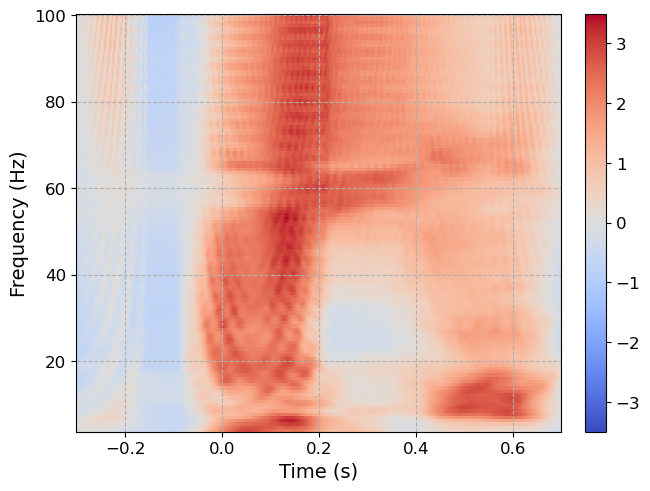

In [26]:
plot_evoked_tfr(tfr, data_in['freq'], time)

## Correlation Between MUA and Aperiodic Params

In [5]:
# load data
df_mua = pd.read_csv(f'{EXTERNAL_PATH}/data/results/mua_df.csv', index_col=0)
df_lfp = pd.read_csv(fr"{EXTERNAL_PATH}\data\results\lfp_spectral_params.csv", index_col=0) # load LFP spectral parameter results

# merge both dataframes
results_df = pd.merge(left=df_lfp, right=df_mua, on= ["session", "array", "channel", "epoch"])
results_df

,session,channel,chan_idx,array,epoch,offset,knee,exponent,alpha_cf,alpha_pw,alpha_bw,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared,mua
0,A_SNR_140819,0,0,1,pre,5.774364,-6.789797,2.264008,9.805430,0.663349,5.275753,17.365468,0.618030,10.053661,60.675713,0.575678,2.164377,0.064003,0.994617,1.905090
1,A_SNR_140819,1,1,1,pre,6.041152,4.586532,2.449866,NaN,NaN,NaN,16.674368,0.648848,12.000000,60.706228,0.607547,2.080446,0.075752,0.991611,1.966392
2,A_SNR_140819,2,2,1,pre,5.513418,-3.240593,1.956623,10.471750,0.483946,4.875697,17.742891,0.396295,12.000000,60.127900,0.400871,2.001077,0.065324,0.990826,2.518872
3,A_SNR_140819,3,3,1,pre,6.029085,7.909415,2.459045,NaN,NaN,NaN,17.123952,0.615339,12.000000,60.970030,0.667564,2.000000,0.074475,0.991993,2.025281
4,A_SNR_140819,4,4,1,pre,5.998930,7.405537,2.411469,NaN,NaN,NaN,17.093011,0.599103,12.000000,60.682388,0.671076,2.228288,0.071394,0.992443,2.039145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,L_SNR_250717,59,1019,16,post,6.597218,-4.360148,1.914368,NaN,NaN,NaN,17.007503,0.306629,4.252543,58.515674,0.536050,2.157331,0.077426,0.984753,5.921929
4092,L_SNR_250717,60,1020,16,post,7.235486,25.438139,2.209834,NaN,NaN,NaN,24.249733,0.229140,2.187178,58.665548,0.454112,2.211706,0.067791,0.986501,5.528276
4093,L_SNR_250717,61,1021,16,post,7.419636,29.715929,2.295010,NaN,NaN,NaN,23.629867,0.242662,3.318244,58.638905,0.432759,2.142921,0.072445,0.988839,5.299164
4094,L_SNR_250717,62,1022,16,post,7.256606,15.471685,2.214591,NaN,NaN,NaN,25.983614,0.255546,11.720273,58.680252,0.466644,2.000000,0.073304,0.987195,4.856267


In [18]:
pre = results_df[results_df['epoch'] == "pre"]
post = results_df[results_df['epoch'] == "post"]
df_merge = post.merge(pre, on=['session','channel','chan_idx','array'], suffixes=['_post', '_pre'])
df_merge = df_merge.drop(columns=['epoch_pre','epoch_post'])
variables = ['knee', 'exponent', 'offset', 'mua', 'r_squared']
for var in variables : 
    df_merge[f'{var}_diff'] = df_merge[f'{var}_post'] - df_merge[f'{var}_pre']
df_merge

,session,channel,chan_idx,array,offset_post,knee_post,exponent_post,alpha_cf_post,alpha_pw_post,alpha_bw_post,...,gamma_pw_pre,gamma_bw_pre,error_pre,r_squared_pre,mua_pre,knee_diff,exponent_diff,offset_diff,mua_diff,r_squared_diff
0,A_SNR_140819,0,0,1,7.058433,148.250363,2.823856,11.558380,0.570986,5.864213,...,0.575678,2.164377,0.064003,0.994617,1.905090,155.040160,0.559848,1.284069,0.004242,-0.002246
1,A_SNR_140819,1,1,1,7.236914,386.448355,2.960241,11.700811,0.567656,5.758776,...,0.607547,2.080446,0.075752,0.991611,1.966392,381.861823,0.510375,1.195761,0.013068,-0.000532
2,A_SNR_140819,2,2,1,6.580895,71.041937,2.445674,11.568723,0.570018,5.964960,...,0.400871,2.001077,0.065324,0.990826,2.518872,74.282530,0.489051,1.067476,0.006051,0.000211
3,A_SNR_140819,3,3,1,7.154523,370.623953,2.933360,11.868307,0.600398,5.766834,...,0.667564,2.000000,0.074475,0.991993,2.025281,362.714539,0.474315,1.125438,0.005437,-0.000298
4,A_SNR_140819,4,4,1,7.055264,268.071112,2.863218,11.959387,0.632763,5.616408,...,0.671076,2.228288,0.071394,0.992443,2.039145,260.665575,0.451749,1.056334,0.007378,0.000240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,L_SNR_250717,59,1019,16,6.597218,-4.360148,1.914368,NaN,NaN,NaN,...,0.322930,2.001151,0.068491,0.988875,3.219166,-1.096749,-0.101930,0.479899,2.702763,-0.004122
2044,L_SNR_250717,60,1020,16,7.235486,25.438139,2.209834,NaN,NaN,NaN,...,0.262925,2.000000,0.065699,0.989644,3.522726,26.435478,0.231901,0.999437,2.005550,-0.003143
2045,L_SNR_250717,61,1021,16,7.419636,29.715929,2.295010,NaN,NaN,NaN,...,NaN,NaN,0.077596,0.986685,3.342198,28.730431,0.149689,0.976125,1.956967,0.002154
2046,L_SNR_250717,62,1022,16,7.256606,15.471685,2.214591,NaN,NaN,NaN,...,0.279519,2.007505,0.065440,0.991935,3.009013,16.767995,0.122122,0.934470,1.847254,-0.004740


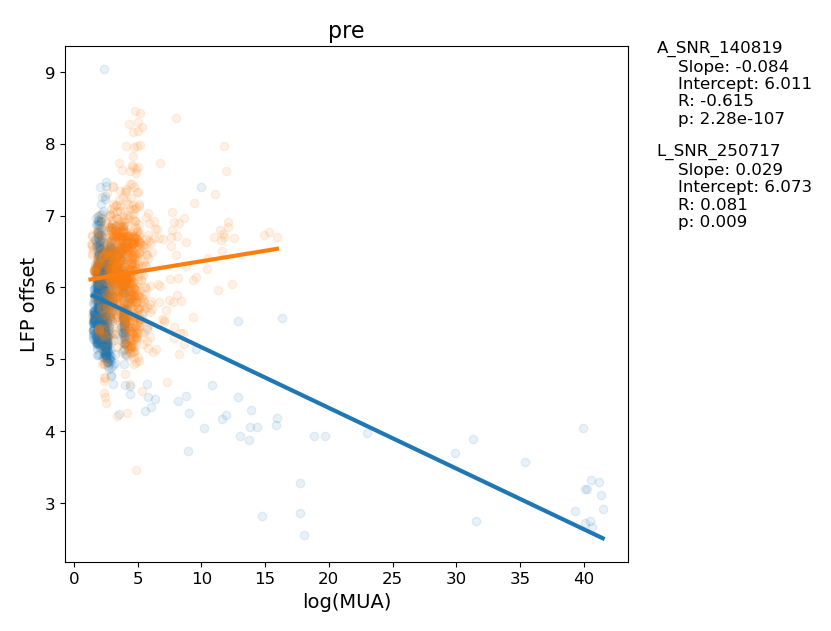

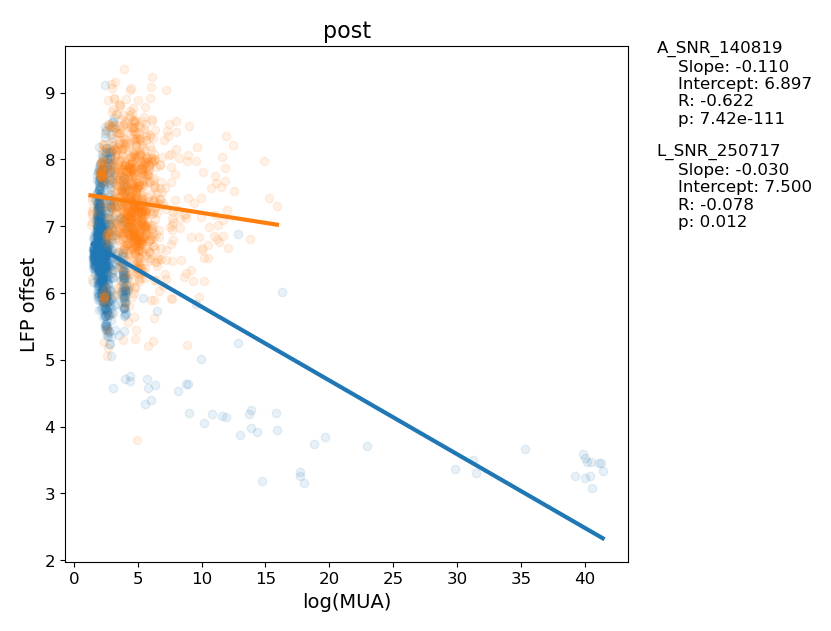

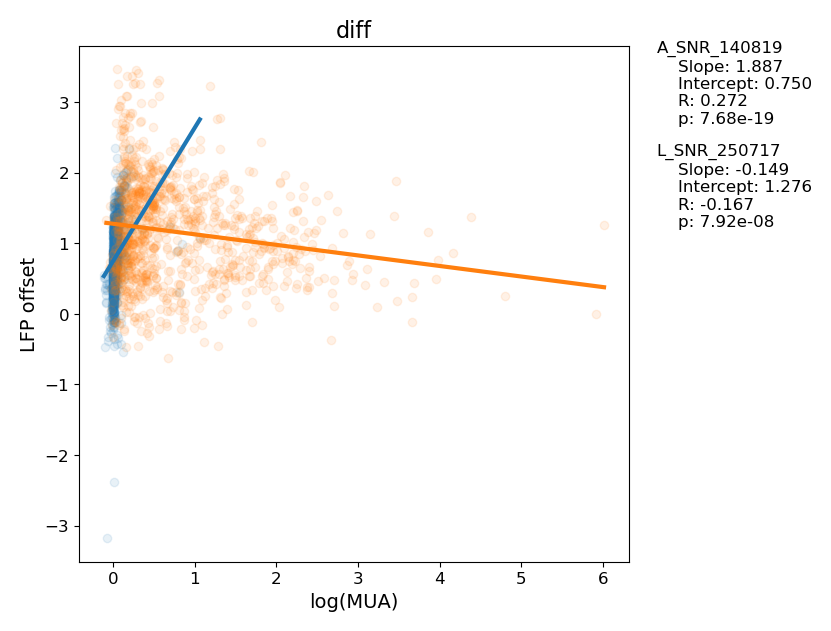

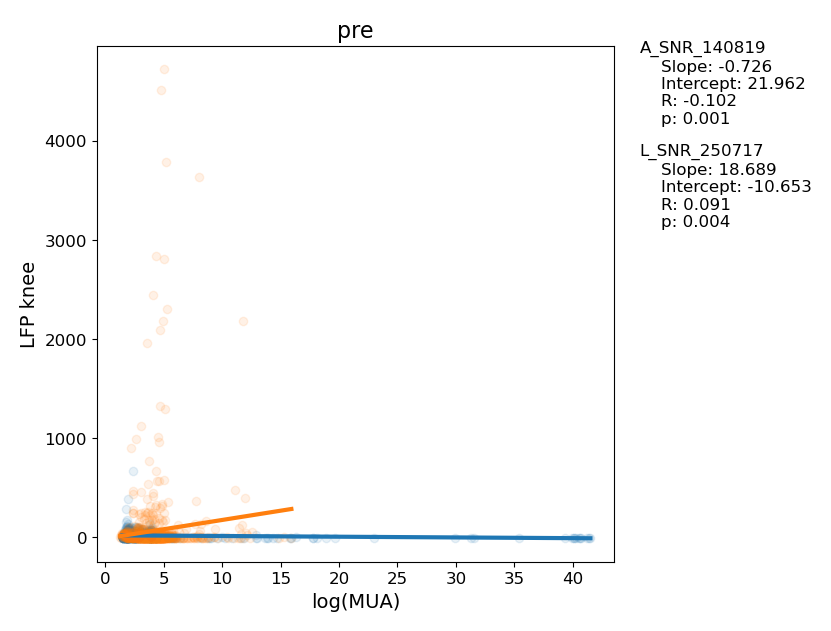

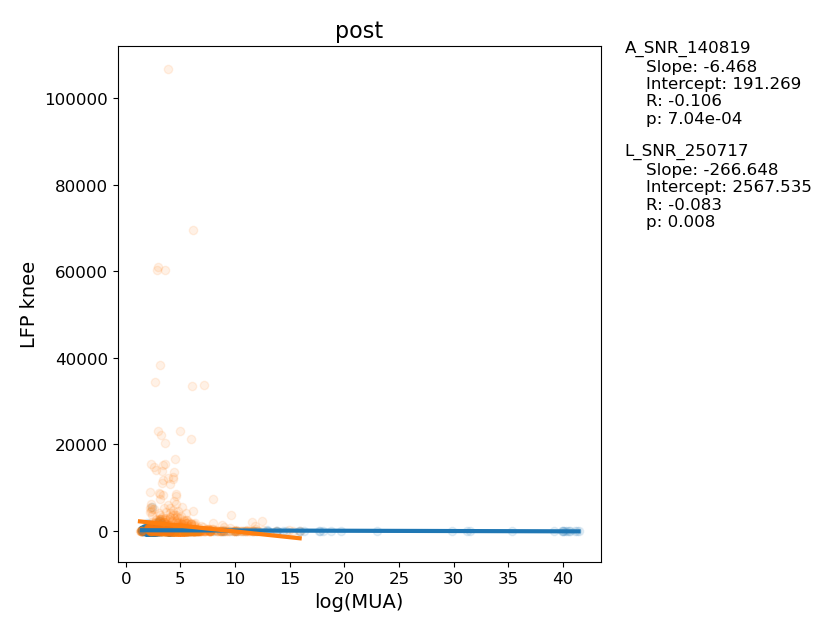

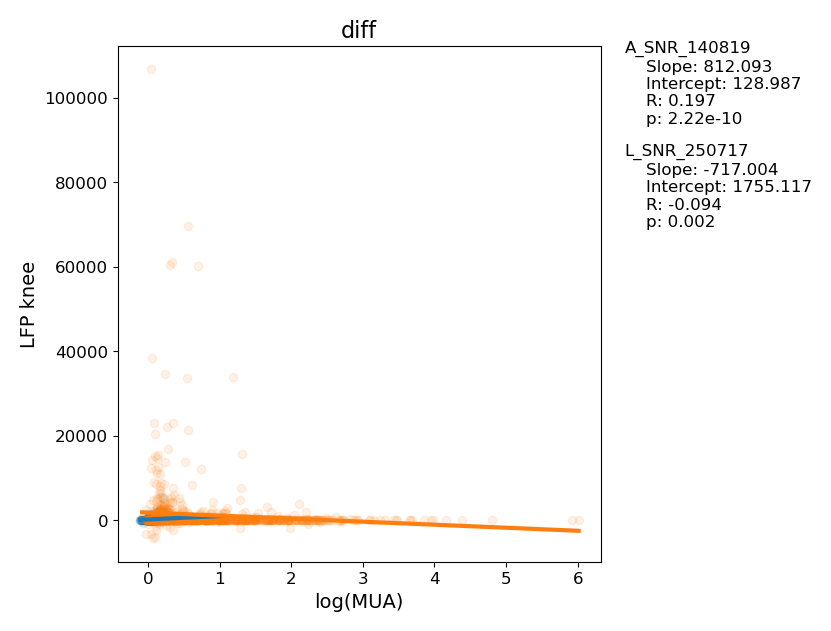

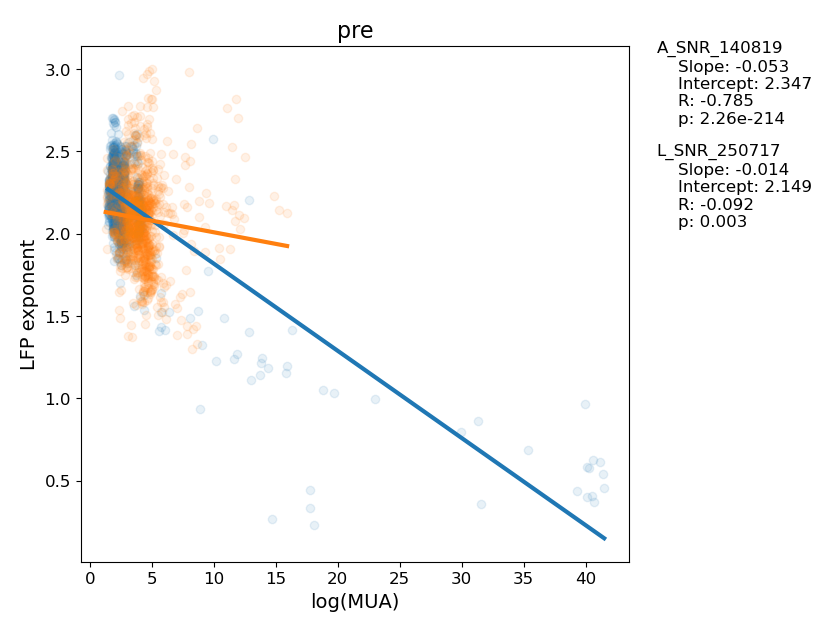

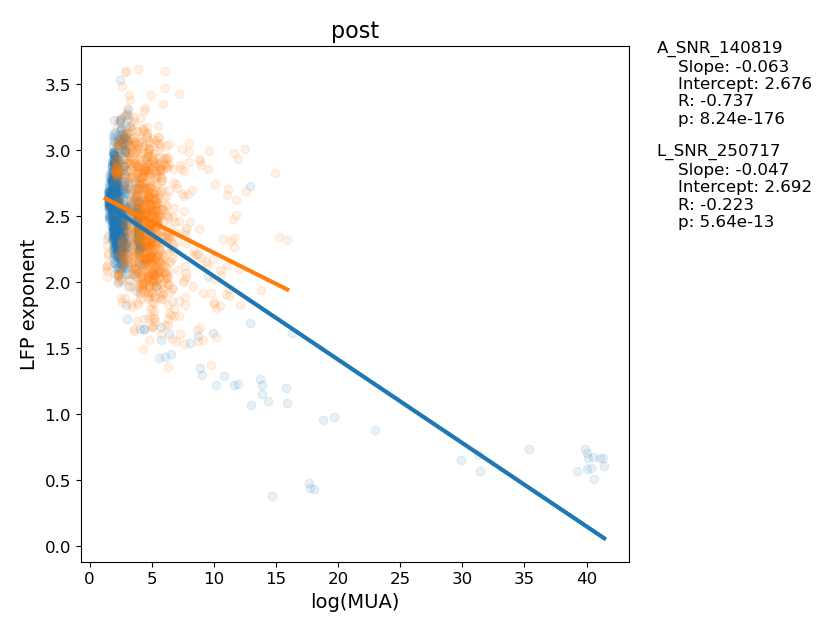

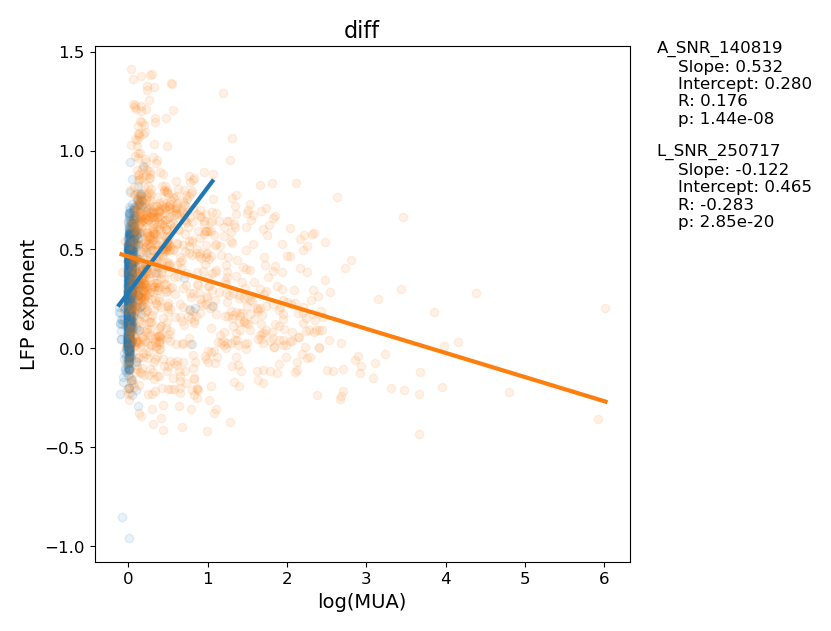

In [19]:
for var in vars:

    for epoch in ['pre', 'post', 'diff']:
        for i_session, session in enumerate(SESSIONS):
            DIR_FIG = f"{EXTERNAL_PATH}/figures/mua/{session}"
            if not os.path.exists(DIR_FIG):
                os.makedirs(DIR_FIG)

            x_data = df_merge.loc[df_merge['session']==session][f'mua_{epoch}']
            y_data = df_merge.loc[df_merge['session']==session][f'{var}_{epoch}']

            if i_session == 0:
                plot_regression(x_data, y_data, title=epoch, xlabel='log(MUA)', ylabel=f'LFP {var}', label=session, label_offset=0.2*i_session)
            else:    
                ax = plt.gca()
                plot_regression(x_data, y_data, ax=ax, title=epoch, xlabel='log(MUA)', ylabel=f'LFP {var}', label=session, label_offset=0.2*i_session)

        # save
        plt.savefig(fr"{DIR_FIG}\linregress_mua_{var}_{epoch}.png")


## Time Resolved Analysis: Correlation Between MUA and Aperiodic Params

In [20]:
# deprecated session (A_SNR_041018) makes up for the first 512000 values in mua_stm_all df, assigning mua values to lfps df does not mess up with the order
lfps = pd.read_csv(r"E:\data\results\lfp_stm_params.csv")
mua_stm_all = pd.read_csv(r"E:\data\results\lfp_stm_params_mua.csv")
mua_stm = mua_stm_all.loc[mua_stm_all['session'].isin(SESSIONS)]
stm = lfps.assign(mua=mua_stm['mua'].values)

In [21]:
stm

,Unnamed: 0,session,channel,chan_idx,array,event,window,offset,knee,exponent,...,alpha_bw,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared,mua
0,0,A_SNR_140819,0,0,1,0,0,6.666685,102.280925,2.734478,...,NaN,17.134416,0.191596,10.460282,61.211571,0.217696,6.067928,0.042960,0.996685,1.890025
1,1,A_SNR_140819,0,0,1,0,1,6.663616,100.171538,2.730763,...,NaN,17.076232,0.195526,10.580613,61.128200,0.212813,5.968571,0.041349,0.996777,1.868100
2,2,A_SNR_140819,0,0,1,0,2,6.671293,101.145178,2.733259,...,NaN,17.037224,0.195683,10.590222,61.107717,0.208992,5.973143,0.040632,0.996864,1.860983
3,3,A_SNR_140819,0,0,1,0,3,6.686993,104.546971,2.740613,...,NaN,17.016690,0.193568,10.541623,61.158962,0.207436,6.063875,0.040224,0.996986,1.894329
4,4,A_SNR_140819,0,0,1,0,4,6.715422,111.589998,2.755093,...,NaN,17.017019,0.185941,10.309504,61.279244,0.209248,6.215993,0.041549,0.996863,1.892372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023995,1023995,L_SNR_250717,63,1023,16,1023,495,6.877031,37.444586,2.148888,...,NaN,20.031582,0.348572,6.991441,61.558778,0.167880,4.951304,0.043294,0.994231,5.055824
1023996,1023996,L_SNR_250717,63,1023,16,1023,496,6.999452,43.087746,2.234459,...,NaN,20.278141,0.328202,7.314931,90.732857,0.162465,12.000000,0.046523,0.992849,5.253525
1023997,1023997,L_SNR_250717,63,1023,16,1023,497,6.749375,15.875746,2.080711,...,NaN,18.995099,0.379869,4.466563,NaN,NaN,NaN,0.043623,0.993911,5.049650
1023998,1023998,L_SNR_250717,63,1023,16,1023,498,6.740675,18.118339,2.079315,...,NaN,19.084583,0.368570,4.414122,NaN,NaN,NaN,0.044872,0.993626,4.720909


session : A_SNR_140819
starting var : offset
subtracting baseline
starting var : exponent
subtracting baseline
starting var : mua
subtracting baseline


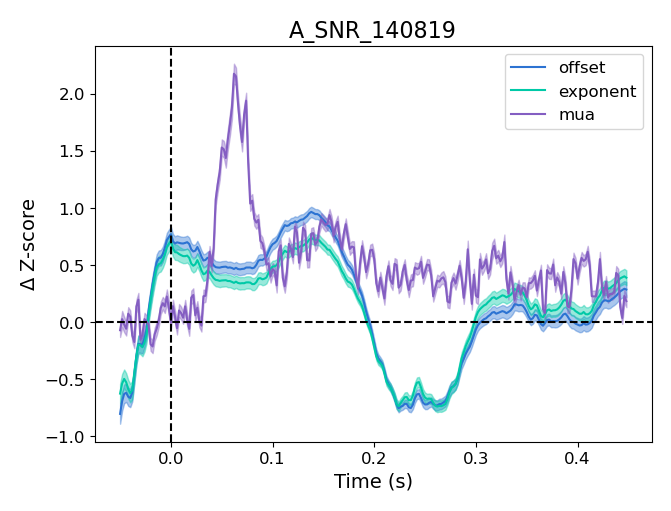

session : L_SNR_250717
starting var : offset
subtracting baseline
starting var : exponent
subtracting baseline
starting var : mua
subtracting baseline


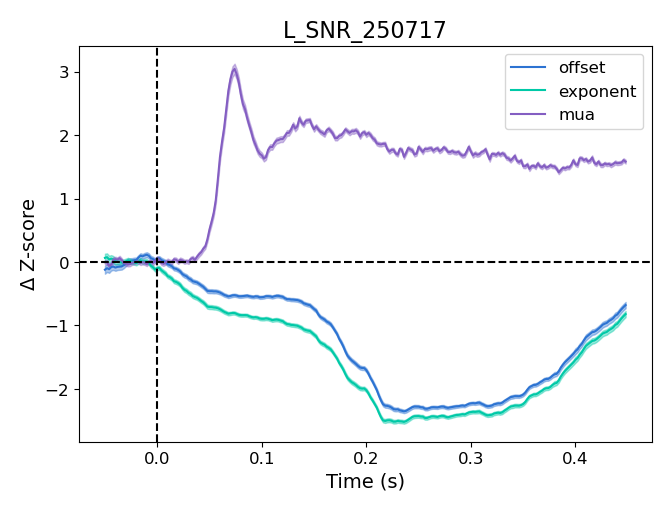

In [34]:
for session in SESSIONS:
    print(f'session : {session}')

    # create directory for figure output
    dir_figs = f"{EXTERNAL_PATH}/figures/mua"
    if not os.path.exists(dir_figs):
        os.makedirs(dir_figs)


    # get df for one session and include time variable
    session_df_mua = stm[stm.get('session') == session].loc[((stm['window']>124) & (stm['window']<375))]
    session_df_mua['time'] = (session_df_mua.get('window')/FS) + EPOCH_TIMES[0]

    vars = ['offset', 'exponent', 'mua']
    ci = {'lci_offset':[], 'rci_offset':[], 'lci_exponent':[], 'rci_exponent':[], 'lci_mua':[], 'rci_mua':[]}

    for var in vars:
        print(f'starting var : {var}')
        count = 0
        z_vars = np.array([])

        for i in range(TOTAL_CHANS):
            # channel zscore values
            data_a = session_df_mua.iloc[np.arange(count, count + 250)]

            z_var = zscore(data_a[var], nan_policy='omit')
            z_vars = np.append(z_vars, z_var)

            count = count + 250

        # add zscore and time variables to df
        session_df_mua[f"z_{var}"] = z_vars
        
        # subtract baseline
        print('subtracting baseline')
        session_df_mua[f'relative_{var}'] = subtract_baseline(session_df_mua.get(f'z_{var}'), session_df_mua.get('time'), np.array([session_df_mua.get('time').min(), 0]))

        # compute left and right endpoint confidence intervals
        lci_var = np.array([])
        rci_var = np.array([])

        for i in np.unique(session_df_mua.get('window')):
            window_df = session_df_mua[session_df_mua.get('window') == i]

            ci_var = compute_confidence_interval(window_df.get(f'relative_{var}'))
            ci[f'lci_{var}'].append(ci_var[0])
            ci[f'rci_{var}'].append(ci_var[1])
        
    # average components per window
    session_df_mua = session_df_mua.groupby('window').mean().reset_index()

    # plot variables
    fig, ax = plt.subplots()
    ax.plot(session_df_mua.get('time'), session_df_mua.get('relative_offset'), c='#2C73D2', label='offset')
    ax.fill_between(session_df_mua.get('time'), ci.get('lci_offset'), ci.get('rci_offset'), color='#2C73D2', alpha=0.4)

    ax.plot(session_df_mua.get('time'), session_df_mua.get('relative_exponent'), c='#00C9A7', label='exponent')
    ax.fill_between(session_df_mua.get('time'), ci.get('lci_exponent'), ci.get('rci_exponent'),  color='#00C9A7', alpha=0.4)

    ax.plot(session_df_mua.get('time'), session_df_mua.get('relative_mua'), c='#845EC2', label='mua')
    ax.fill_between(session_df_mua.get('time'), ci.get('lci_mua'), ci.get('rci_mua'),  color='#845EC2', alpha=0.4)

    ax.set_title(f'{session}')
    ax.set_xlabel('Time (s)')
    plt.legend()
    ax.set_ylabel(r'$\Delta$ Z-score')
    ax.axhline(y=0, color='k', linestyle='--')
    ax.axvline(x=0, color='k', linestyle='--')
    plt.show()
    
    fig.savefig(f'{dir_figs}/{session}_zscore')